As promissed last week, this week, we will show a simple example how [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) works. I tried to find online with a nice animation, but I can not find it. Therefore, this week, let's just create a simple movie of showing how autocorrelation works. 

In [41]:
from statsmodels import api as sm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as manimation

plt.style.use('seaborn-poster')
%matplotlib inline

## Generate a sine signal

Let's first generate a sine wave with frequency 0.1 Hz, and we can sample it sampling rate 1 Hz. We can plot the figure as showing below:

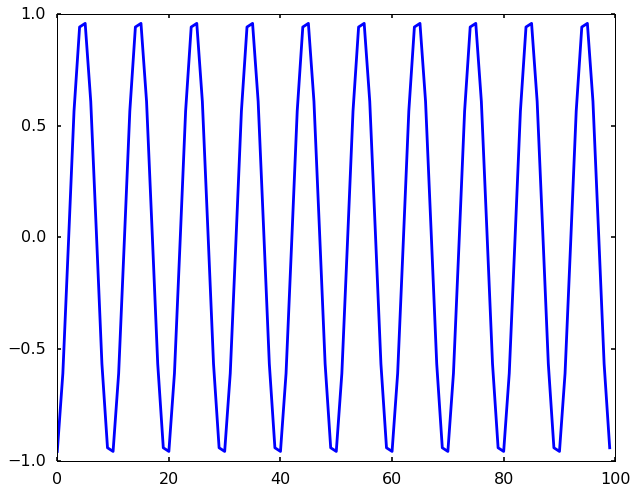

In [57]:
Fs = 1  # sampling rate
Ts = 1.0/Fs # sampling interval
t = np.arange(0,100,Ts) # time vector
ff = 0.1;   # frequency of the signal
# create the signal
y = np.sin(2*np.pi*ff*t + 5)

plt.figure(figsize = (10, 8))
plt.plot(t, y)
plt.show()

## Plot the autocorrelation using statsmodels

We can first plot the autocorrelation using an existing package - [statsmodels](http://statsmodels.sourceforge.net/). The idea of autocorrelation is to provide a measure of similarity between a signal and itself at a given lag. We can see the following figure. Maybe you think it is hard to understand from text description, let's create an animation in the next section to reproduce this figure, and hope you will have a better understand there. 

In [44]:
# get the autocorrelation coefficient
acf = sm.tsa.acf(y, nlags=len(y))

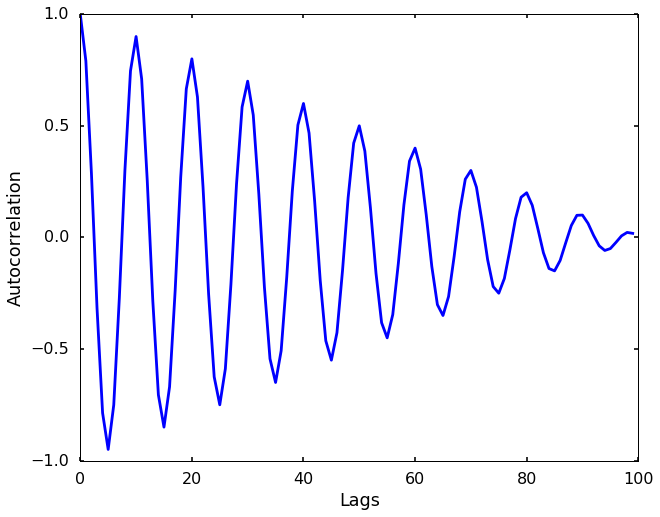

In [45]:
plt.figure(figsize = (10, 8))
lag = np.arange(len(y))
plt.plot(lag, acf)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

## Let's make a simple movie to show how it works

In this section, we will reprouce the above figure and make a simple animation to show how it works. As we talked last time, it is a simple method in the time domain that you shift the signal with a time lag and calculate the correlation with the original signal (or we can simply multiply the two signals to get a number, and then we can divide the largest number to scale the value to -1 to 1). We can use the functions we talked before to [shift the signal in the frequency domain](http://qingkaikong.blogspot.com/2016/03/shift-signal-in-frequency-domain.html) as show in the following cell. 

In [46]:
def nextpow2(i):
    '''
    Find the next power 2 number for FFT
    '''
    
    n = 1
    while n < i: n *= 2
    return n

def shift_signal_in_frequency_domain(datin, shift):
    '''
    This is function to shift a signal in frequency domain. 
    The idea is in the frequency domain, 
    we just multiply the signal with the phase shift. 
    '''
    Nin = len(datin) 
    
    # get the next power 2 number for fft
    N = nextpow2(Nin +np.max(np.abs(shift)))
    
    # do the fft
    fdatin = np.fft.fft(datin, N)
    
    # get the phase shift for the signal, shift here is D in the above explaination
    ik = np.array([2j*np.pi*k for k in xrange(0, N)]) / N 
    fshift = np.exp(-ik*shift)
        
    # multiple the signal with the shift and transform it back to time domain
    datout = np.real(np.fft.ifft(fshift * fdatin))
    
    # only get the data have the same length as the input signal
    datout = datout[0:Nin]
    
    return datout

Let's make the movie below. We will shift the signal 1 at a step, and calculate a simple correlation normalized by the largest value (the two signals overlap with each other, or 0 lag). 

In [47]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

In [ ]:
lags = []
acfs = []
norm = np.dot(y, y)
fig = plt.figure(figsize = (10, 8))
n_frame = len(y)

def updatefig(i):
    '''
    a simple helper function to plot the two figures we need, 
    the top panel is the time domain signal with the red signal
    showing the shifted signal. The bottom figure is the one
    corresponding to the autocorrelation from the above figure. 
    '''
    fig.clear()
    # shift signal
    y_shift = shift_signal_in_frequency_domain(y, i)
    plt.subplot(211)
    plt.plot(t, y, 'b')
    plt.plot(t, y_shift, 'r')
    plt.ylabel('Amplitude')
    plt.title('Lag: ' + str(i))

    plt.subplot(212)
    # get the lag
    lags.append(i)
    # simple way to calculate autocorrelation
    acf = np.dot(y_shift, y)
    # add to the list with normalized value. 
    acfs.append(acf/norm)
    plt.plot(lags, acfs)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.xlim(0, n_frame)
    plt.ylim(-1, 1)
    plt.draw()

# save the movie to file
anim = manimation.FuncAnimation(fig, updatefig, n_frame)
anim.save("./autocorrelation_example.mp4", fps=10, dpi = 300)

# somehow there's always a figure generating here, but it is not affect the movie

![gif](./autocorrelation_example.gif)

We can now have a much better view of how autocorrelation works. We shift the signal by 1 at a time, and calculate the autocorrelation as the following steps: 
1. multiply the numbers from two signals at each timestamp (You can think two signals as two array, and we do an elementwise multipy of the two arrays)
2. after teh elementwise multiplication, we get another array, which we will sum them up to get a number - the autocorrelation. 

This is basically the dot product of the two signals. We can see as the red signal shifted away from the very beginning of the total overlap, the two signals start to out of phase, and the autocorrelation decreasing. Due to the signal is a periodic signal, the red signal soon overlap with the blue signal again. But we can see as the red signal shifted certain lags, it only partially overlap with the original blue signal, therefore, the autocorrelation of the 2nd peak is smaller than the first peak. As the red signal shifted further, the part overlap becomes smaller, which generating the decreasing trend of the peaks. 

I hope now you have a better understanding how the autocorrelation works!

PS: I use the following command to convert mp4 to gif if you want to do the same thing

```bash
ffmpeg -i autocorrelation_example.mp4 -vf scale=768:-1 -r 10 -f image2pipe -vcodec ppm - | convert -delay 10 -loop 0 - output.gif
```